In [15]:
import sys
import numpy as np
import pandas as pd
import h5py
from scipy.ndimage import mean as sp_mean
from scipy import optimize
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Polygon
from scipy.signal import find_peaks_cwt, ricker, cwt, find_peaks
from scipy.interpolate import interpn, interp1d
import warnings
import time
from collections import Iterable
import itertools

warnings.filterwarnings("ignore")

pixel_size = 2e5
detector_distance = 5.465e9
wavelength = 0.1348

pixel_q = 2 * np.pi * pixel_size / wavelength / detector_distance

def filename_from_run(run):
    return "/s/ls4/groups/g0065/xfel/data/hits_r{:04d}.h5".format(int(run))

def find_theor_max(r):
    grid = np.linspace(0.02, 0.08, 1000)
    vals = sphere_ff(grid, r, 1)
    maxs = []
    for i in range(1, 999):
        if vals[i] >= vals[i - 1] and vals[i] >= vals[i + 1]:
            maxs.append(grid[i])
    return maxs

theor = find_theor_max(250)

def progressBar(value, endvalue, bar_length=20, title="Percent:"):
        if endvalue == 0:
            percent = 1.0
        else:
            percent = float(value) / endvalue
        arrow = '-' * int(round(percent * bar_length)-1) + '>'
        spaces = ' ' * (bar_length - len(arrow))

        sys.stdout.write("\r{0:s} [{1}] {2:.2f}%".format(title ,arrow + spaces, percent * 100))
        sys.stdout.flush()

def interp_average(image, mask, center, step=None, rmax=None):
    step = step or 1
    if rmax is not None:
        image = image[int(center[0]) - rmax:int(center[0]) + rmax + 1, int(center[1]) - rmax:int(center[1]) + rmax + 1]
        mask = mask[int(center[0]) - rmax:int(center[0]) + rmax + 1, int(center[1]) - rmax:int(center[1]) + rmax + 1]
        center = (center[0] - int(center[0]) + rmax, center[1] - int(center[1]) + rmax)
    if rmax is None:
        rmax = np.sqrt(np.max((image.shape[0] - 1 - center[0], center[0])) ** 2 + 
                       np.max((image.shape[1] - 1 - center[1], center[1])) ** 2)
    averaged = []
    qs = []
    for r in np.arange(step, rmax, step):
        ang = np.linspace(0, 2 * np.pi, int(2 * np.pi * r / step), endpoint=False)
        points = np.transpose(np.vstack((center[0] + r * np.cos(ang), center[1] + r * np.sin(ang))))
        values = interpn((np.arange(image.shape[0]), np.arange(image.shape[1])), image, points, bounds_error=False, fill_value=0)
        mask_values = interpn((np.arange(image.shape[0]), np.arange(image.shape[1])), mask, points, method='linear', bounds_error=False, fill_value=0)
        averaged.append(np.sum(values[mask_values > 0.999]) / np.sum(mask_values > 0.999))
        qs.append(r * pixel_q)
    qs = np.array(qs)
    psd = np.array(averaged)
    qs = qs[np.logical_not(np.isnan(psd))]
    psd = psd[np.logical_not(np.isnan(psd))]
    return qs, psd

def angle_average(image, mask, center, rmax=None):
    if rmax is not None:
        image = image[int(center[0]) - rmax:int(center[0]) + rmax + 1, int(center[1]) - rmax:int(center[1]) + rmax + 1]
        mask = mask[int(center[0]) - rmax:int(center[0]) + rmax + 1, int(center[1]) - rmax:int(center[1]) + rmax + 1]
        center = (center[0] - int(center[0]) + rmax, center[1] - int(center[1]) + rmax)
    sx, sy = image.shape
    X, Y = np.ogrid[0:sx, 0:sy]
    radius = np.hypot(X - center[0], Y - center[1])
    rbins = radius.astype(np.int32)
    rbins[mask == False] = -1
    if rmax is not None:
        rbins[rbins > rmax] = -1
    qs = (np.arange(0, rbins.max()+1) + 0.5) * pixel_q
    psd = sp_mean(image, rbins, np.arange(0, rbins.max() + 1))
    qs = qs[np.logical_not(np.isnan(psd))]
    psd = psd[np.logical_not(np.isnan(psd))]
    return qs, psd

def sphere_ff(q, r, c=3):
    qr = q * r 
    values =  c / (qr ** 6) * (np.sin(qr) - qr * np.cos(qr)) ** 2 
    if isinstance(values, Iterable):
        values = np.array(values)
        values[np.isnan(values)] = c / 9
    elif np.isnan(values):
        values = c / 9
    return values

def sphere_ff_der(q, r, c=3):
    qr = q * r
    return np.transpose(np.vstack((c * (2 * q / (qr ** 5) * np.sin(qr) * (np.sin(qr) - qr * np.cos(qr))
            - 6 / (qr ** 7) * (np.sin(qr) - qr * np.cos(qr)) ** 2), (np.sin(qr) - qr * np.cos(qr)) ** 2 / qr ** 6)))


def plot_fit(x, y, params, log=False):
    if log:
        plt.yscale('log')
    fine_x = np.linspace(x[0], x[-1], 10000)
    plt.plot(fine_x, sphere_ff(fine_x, params[0], params[1]), x, y)
    plt.show()

def wavelet(points, width):
    num = int(width * 10)
    angles = np.linspace(1.35 * np.pi, 2.4 * np.pi, num)
    if points < num:
        angles = angles[(num - points) // 2:-((num - points) // 2)][:points]
    values = ((np.sin(angles) - angles * np.cos(angles)) / ((angles) ** 3)) ** 2
    values[np.isnan(values)] = 1
    return values

def wavelet2(points, width):
    num = int(width * 5)
    angles = np.linspace(1.35 * np.pi, 2.4 * np.pi, num)
    if points < num:
        angles = angles[(num - points) // 2:-((num - points) // 2)][:points]
    values = ((np.sin(angles) - angles * np.cos(angles)) / ((angles) ** 3)) ** 2
    values[np.isnan(values)] = 1
    if points > len(values):
        points = np.round(points).astype(int)
        values = np.concatenate((np.zeros((points - len(values)) // 2), 
                                 values, 
                                 np.zeros(points - len(values) - (points - len(values)) // 2)))
    return values

def weighted_mean(seq, weights):
    if len(seq) == 0:
        return 0
    if len(weights) < len(seq):
        return 0
    summ = 0
    count = 0
    for i in range(len(seq)):
        summ += weights[i] * seq[i]
        count += weights[i]
    return summ / count

def radius_from_period(image, mask, center, output='all', factor=1):
    center_region = [slice(c - 200 * factor, c + 200 * factor) for c in center]
    qs, psd = angle_average(image[center_region], mask[center_region], (200 * factor, 200 * factor))
    qs = qs[np.logical_not(np.isnan(psd))]
    psd = psd[np.logical_not(np.isnan(psd))]
    peaks = find_peaks_cwt(psd, np.arange(0.5 * factor, 2.5 * factor, 0.1 * factor), max_distances=np.ones(20) * 2, wavelet=wavelet)[:10]
    peak_coords = qs[peaks]
    merged_peaks = []
    streak = False
    # merge together peaks that are registered 1 pixel apart as it's impossible to resolve 1 pixel ring
    for i in range(len(peaks) - 1):
        if not streak:
            summ = peak_coords[i]
            num = 1
        if peaks[i] == peaks[i + 1] - 1:
            summ += peak_coords[i + 1]
            num += 1
            streak = True
        else:
            streak = False
        if not streak:
            merged_peaks.append(summ / num)
    saved = merged_peaks.copy()
    # merge together peaks that are too close
    not_parsed = True
    likely_period = 0
    while not_parsed:
        periods = np.diff(merged_peaks)
        likely_period = weighted_mean(periods, np.arange(len(periods), 0, -1))
        not_parsed = False
        streak_start = -1
        streak_end = -1
        for i in range(1, len(merged_peaks)):
            if merged_peaks[i] - merged_peaks[i - 1] < likely_period * 0.5:
                if streak_start < 0:
                    streak_start = i - 1
                    streak_end = i
                else:
                    streak_end = i
            if streak_start > 0 and (merged_peaks[i] - merged_peaks[i - 1] >= likely_period * 0.5 or i == len(merged_peaks) - 1):
                summ = merged_peaks[streak_end]
                num = 1
                for j in range(streak_start, streak_end):
                    summ += merged_peaks[j]
                    num += 1
                merged_peaks[streak_end] = summ / num
                merged_peaks = [merged_peaks[k] for k in range(len(merged_peaks)) if k not in range(streak_start, streak_end)]
                not_parsed = True
                break
    #relevant_peaks = merged_peaks[:6]
    if psd[1] > psd[0]:
        start = 0
    else:
        start = 1
    
    if output == 'all':
        plt.figure(figsize=(14,8))
        plt.yscale('log')
        plt.xlabel('Radius')
        plt.ylabel('Intensity')
        for p in merged_peaks:
            plt.axvline(p)
        for p in saved:
            plt.axvline(p, alpha=.7, linestyle="--", color="green")
        plt.plot(qs, psd, "r")
    
    if len(merged_peaks) - start < 2:
        if output == 'all':
            print(" Image is too bad to estimate radius, skipping")
            plt.figure(figsize = (4,4))
            plt.imshow(image[center[0] - 100 * factor:center[0] + 100 * factor, center[1] - 100 * factor:center[1] + 100 * factor], norm=LogNorm())
        return qs, psd, 0, merged_peaks
            
    return (qs, 
            psd, 
            np.pi / (merged_peaks[-1] - merged_peaks[start]) * (len(merged_peaks) - 1 - start), 
            merged_peaks)

def get_image_mask(filename, frame_number):
    with h5py.File(filename, "r") as f:
        image = f["assembled"]["photons"][frame_number, :, :]
        mask = np.logical_not(f["assembled"]["mask"][frame_number, :, :])
        # this moves bottom panel 1 pixel to the right
        image[600:, 671:] = image[600:, 670:-1]
        mask[600:, 671:] = mask[600:, 670:-1]
    return image, mask

def enhance(image, mask, factor):
    enhanced_image = np.zeros([image.shape[0] * factor, image.shape[1] * factor])
    enhanced_mask = np.zeros([mask.shape[0] * factor ,mask.shape[1] * factor])
    global pixel_q
    pixel_q = 2 * np.pi * pixel_size / wavelength / detector_distance / factor
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            enhanced_image[i * factor:i * factor + factor, j * factor:j * factor + factor] = image[i, j]
            enhanced_mask[i * factor:i * factor + factor, j * factor:j * factor + factor] = mask[i, j]
    return enhanced_image, enhanced_mask

def convert(center, factor):
    return tuple((2 * c - factor + 1) / 2 / factor for c in center)

def identify_good_frames(run_list, c0, threshold=0.15):
    good_images = {}
    good_scores = {}
    for run in run_list:
        potentially_good = []
        scores = {}
        num_frames = 0
        filename = filename_from_run(run)
        with h5py.File(filename, "r") as f:
            num_frames = f["TrainID"].shape[0]
        print("Run {}, {} frames".format(run, num_frames))
        for frame in range(num_frames):
            progressBar(frame, num_frames - 1, 40, "")
            image, mask = get_image_mask(filename, frame)
            qs, psd, r, peaks = radius_from_period(image, mask, c0, 'none')
            if len(peaks) > 7:
                periods = np.diff(peaks)
                score = np.std(periods) / np.mean(periods)
                if score < threshold:
                    potentially_good.append((frame, np.sum(psd)))
                    scores[frame] = score
        sorted_good = sorted(potentially_good, key=lambda kv: kv[1], reverse=True)
        good_images[run] = [e[0] for e in sorted_good[:int(len(sorted_good) * 0.7)]]
        good_scores[run] = [scores[frame] for frame in good_images[run]]
        print("")
    return good_images, good_scores

def show_many_frames(frames_dict, comments={}, approx_center=(600, 700), size=120):
    total_frames = np.sum([len(s) for s in frames_dict.values()])
    cols = 3
    rows = total_frames // 3 + 1
    while rows > 150:
        cols += 1
        rows = total_frames // cols + 1
        
    if cols > 6:
        print("Too many images, only first 900 will be shown")
        cols = 6
        rows = 150

    fig = plt.figure(figsize=(18, 6 * rows))
    i = 0
    done=False
    for run in frames_dict:
        filename = filename_from_run(run)
        for frame in frames_dict[run]:
            if run in comments:
                if frame in comments[run]:
                    comment = comments[run][frame]
                else:
                    comment = ""
            else:
                comment = ""
            image, mask = get_image_mask(filename, frame)
            image = image[approx_center[0] - size:approx_center[0] + size, approx_center[1] - size:approx_center[1] + size]
            axis = fig.add_subplot(rows, cols, i+1)
            short_name = "r{:d}f{:d} {:s}".format(run, frame, comment)
            axis.set_title(short_name)
            plt.imshow(image, interpolation='nearest', norm=LogNorm())
            i += 1
            if i == cols * rows:
                done = True
                break
        if done:
            break

    plt.show()
    
def show_frames_by_radius(radiuses, rmin=0, rmax=800, init_rmin=0, init_rmax=800):
    bs = np.logical_and(radiuses[:, 3] < rmax, radiuses[:, 3] >= rmin)
    bs = np.logical_and(bs, radiuses[:, 2] < init_rmax)
    bs = np.logical_and(bs, radiuses[:, 2] >= init_rmin)
    frame_dict = {}
    comment_dict = {}
    for line in radiuses[bs][:449]:
        run = int(line[0])
        frame = int(line[1])
        if run in frame_dict: 
            frame_dict[run].append(frame)
        else:
            frame_dict[run] = [frame]
            comment_dict[run] = {}
        comment_dict[run][frame] = "{:d} {:d}".format(int(line[2]), int(line[3]))
        
    show_many_frames(frame_dict, approx_center=(609, 714), comments=comment_dict)

def small_particle_radius(qs, psd, verbose=False, factor=1, ax=None):
    parameters = {"wavelet":wavelet2,
                  "widths":np.linspace(3 * factor, 6 * factor, 16), 
                  "gap_thresh":1, 
                  "max_distances":np.ones(16) * 3 * factor, 
                  "min_length":4, 
                  "min_snr":0.1, 
                  "noise_perc":1}
    peaks = find_peaks_cwt(psd, **parameters).astype(int)
    peak_coords = qs[peaks]
    
    #eliminate nearby peaks that don't have suficiently different values
    #prevents some noise at the tail from getting through
    merged_peaks = []
    streak = 0
    streak_sum = 0
    current_max = 0
    for peak, value in zip(peak_coords, psd[peaks]):
        if streak == 0:
            current_max = value
            streak = 1
            streak_sum = peak
        elif streak > 0:
            if value > current_max:
                current_max = value
                streak = 1
                streak_sum = peak
            elif value >= current_max * 0.9:
                streak += 1
                streak_sum += peak
            else:
                merged_peaks.append(streak_sum / streak)
                streak = 1
                current_max = value
                streak_sum = peak
    if streak > 0:
        merged_peaks.append(streak_sum / streak)
    if verbose:
        plt.figure(figsize=(14,8))
        if ax is None:
            ax = plt.axes()
        ax.set_yscale('log')
        ax.set_xlabel('Radius')
        ax.set_ylabel('Intensity')
        for p in merged_peaks:
            ax.axvline(p)
        for p in peak_coords:
            ax.axvline(p, alpha=.5, linestyle="--", color="green", linewidth=1.5)
        ax.plot(qs, psd, "r")
        
    peak_coords = merged_peaks
    if len(peak_coords) > 2:
        return np.pi / np.mean(np.diff(peak_coords))
    else:
        return 0
    
def big_particle_radius(qs, psd, verbose=False, ax=None, factor=1):
    parameters = {"wavelet":wavelet2,
                  "widths":np.linspace(0.8 * factor, 2.4 * factor, 16), 
                  "gap_thresh":1, 
                  "max_distances":np.ones(16) * 3 * factor, 
                  "min_length":4, 
                  "min_snr":0.1, 
                  "noise_perc":1}
    peaks = find_peaks_cwt(psd, **parameters).astype(int)
    peak_coords = qs[peaks]
    if len(peaks) < 2:
        return 0
    # remove first peak if its position is bad
    if psd[peaks[0]] <= np.min(psd[:peaks[0]]):
        peak_coords = peak_coords[1:]
    if len(peak_coords) < 2:
        return 0
    # dicard all peaks beyond the 6th
    peak_coords = peak_coords[:5]
    
    #instead of taking just the average tries to guess how many peaks were missed
    window = 2
    total_length = peak_coords[-1] - peak_coords[0]
    safety_period = find_best_period(peak_coords, window)
    qr = 0 
    while window < len(peak_coords):
        best_period = find_best_period(peak_coords, window) 
        if best_period >= 1.3 * safety_period or best_period <= 0.7 * safety_period:
            qr = safety_period
            if verbose:
                print("Warning, current window is {} btw".format(window))
            return 0
            break
        if np.abs(np.round(total_length / best_period) - total_length / best_period) <= 0.25:
            qr = total_length / np.round(total_length / best_period)
            if verbose:
                print("There's {} periods in here".format(np.round(total_length / best_period)))
            break
        window += 1
        
    if len(peak_coords) >= 2 and qr == 0:
        qr = (peak_coords[-1] - peak_coords[0]) / (len(peak_coords) - 1)
    
    if verbose:
        
        plt.figure(figsize=(14,8))
        if ax is None:
            ax = plt.axes()
        ax.set_yscale('log')
        ax.set_xlabel('$Radius, [\it{nm}^{-1}]$', fontsize=20)
        ax.set_ylabel('$Intensity, [\it{photons}]$', fontsize=20)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        new_coords = [peak_coords[0]]
        idx = 0
        for i in range(len(qs)):
            if np.allclose(peak_coords[idx], qs[i]):
                for j in range(1, 4):
                    if np.abs(peak_coords[idx] + j * best_period - peak_coords[idx + 1]) > np.abs(peak_coords[idx] + (j + 1) * best_period - peak_coords[idx + 1]):
                        new_coords.append(qs[i + int(np.round((j * best_period) / (qs[1] - qs[0])))])
                    else:
                        new_coords.append(peak_coords[idx + 1])
                        break
                idx += 1
                if idx == len(peak_coords) - 1:
                    break
        idx = 0
        marker = 0
        line = 0
        for qi in range(len(qs)):
            if np.allclose(qs[qi], new_coords[idx]):
                if idx == 2:
                    marker, = ax.plot(qs[qi-1], psd[qi-1], "or", markersize=8)
                else:
                    marker, = ax.plot(qs[qi], psd[qi], "or", markersize=8)
                idx += 1
            if idx == len(new_coords):
                break
        line, = ax.plot(qs, psd, color="C0")
        ax.legend(handles = (marker, line), labels=["local maximum", "radial average"], fontsize=20)
    return np.pi / qr

def find_best_period(points, window=3):
    periods = np.diff(points)
    if len(periods) >= window:
        combs = itertools.combinations(periods, window)
        matr = np.array(list(combs))
        stds = np.std(matr, axis=1) #/ np.mean(matr, axis=1) #test feature
        best = np.amin(stds)
        best_period = np.mean(matr[stds == best, :])
        stdscut = stds.copy()
        while best_period > 1.2 * np.mean(periods):
            stdscut = stdscut[stdscut != best]
            best = np.amin(stdscut)
            best_period = np.mean(matr[stds == best, :])
    else:
        best_period = np.mean(periods)
    return best_period

def estimate_radius_runs(runs, center, factor=1):
    t0 = time.time()
    total_frames = 0
    global pixel_q
    pixel_q /= factor
    for run in runs:
        num_frames = 0
        filename = filename_from_run(run)
        with h5py.File(filename, "r") as f:
            total_frames += f["TrainID"].shape[0]
    print("Total of {} frames in {} runs".format(total_frames, len(runs)))
    radiuses = np.zeros([total_frames, 4])
    i = 0
    for run in runs:
        num_frames = 0
        filename = filename_from_run(run)
        with h5py.File(filename, "r") as f:
            num_frames = f["TrainID"].shape[0]
        for frame in range(num_frames):
            progressBar(i, total_frames - 1, 40, "")
            image, mask = get_image_mask(filename, frame)
            qs, psd = interp_average(image, mask, center, rmax=90, step=1 / factor)
            init_r = small_particle_radius(qs, psd, factor=factor)
            if init_r == 0:
                r = big_particle_radius(qs[:60 * factor], psd[:60 * factor], factor=factor)
            else: 
                r = -1
            if np.sum(np.isnan(np.array([run, frame, init_r, r]))):
                print("r{}f{} {} {}".format(run, frame, init_r, r))
                return 0
            radiuses[i] = np.array([run, frame, init_r, r])
            i += 1
    t1 = time.time()
    print("\n{:d} frames processed in {:02d}:{:02d}:{:02d}, average {:.2f}s per frame".format(total_frames,
                                                                                           int(t1-t0) // 3600,
                                                                                           int(t1-t0) % 3600 // 60,
                                                                                           int(t1-t0) % 60,
                                                                                           (t1-t0) / total_frames))
    plt.figure(figsize=(14,8))
    plt.xlabel("Radius")
    plt.ylabel("Images")
    plt.hist(radiuses[radiuses[:, 2] != 0 , 2], np.arange(0, 460, 10), alpha=0.5, color="#1F77B4")
    plt.hist(radiuses[radiuses[:, 3] >= 0, 3], np.arange(0, 460, 10), color="red", alpha=0.6)
    pixel_q = 2 * np.pi * pixel_size / wavelength / detector_distance
    return radiuses

def estimate_radius_runs_new(runs, center, factor=1):
    t0 = time.time()
    total_frames = 0
    global pixel_q
    pixel_q /= factor
    for run in runs:
        num_frames = 0
        filename = filename_from_run(run)
        with h5py.File(filename, "r") as f:
            total_frames += f["TrainID"].shape[0]
    print("Total of {} frames in {} runs".format(total_frames, len(runs)))
    radiuses = np.zeros([total_frames, 6])
    i = 0
    for run in runs:
        num_frames = 0
        filename = filename_from_run(run)
        with h5py.File(filename, "r") as f:
            num_frames = f["TrainID"].shape[0]
        for frame in range(num_frames):
            progressBar(i, total_frames - 1, 40, "")
            image, mask = get_image_mask(filename, frame)
            qs, psd = interp_average(image, mask, center, rmax=90, step=1 / factor)
            init_r = small_particle_radius(qs, psd, factor=factor)
            if init_r == 0:
                r = big_particle_radius(qs[:60 * factor], psd[:60 * factor], factor=factor)
            else: 
                r = -1
            if np.sum(np.isnan(np.array([run, frame, init_r, r]))):
                print("r{}f{} {} {}".format(run, frame, init_r, r))
                return 0
            shift, new_r, score = confirm_filter(qs, psd)
            radiuses[i] = np.array([run, frame, r, new_r, shift, score])
            i += 1
    t1 = time.time()
    print("\n{:d} frames processed in {:02d}:{:02d}:{:02d}, average {:.2f}s per frame".format(total_frames,
                                                                                           int(t1-t0) // 3600,
                                                                                           int(t1-t0) % 3600 // 60,
                                                                                           int(t1-t0) % 60,
                                                                                           (t1-t0) / total_frames))
    plt.figure(figsize=(14,8))
    plt.xlabel("Radius")
    plt.ylabel("Images")
    plt.hist(radiuses[radiuses[:, 2] != 0 , 2], np.arange(0, 460, 10), alpha=0.5, color="#1F77B4")
    plt.hist(radiuses[radiuses[:, 3] >= 0, 3], np.arange(0, 460, 10), color="red", alpha=0.6)
    pixel_q = 2 * np.pi * pixel_size / wavelength / detector_distance
    return radiuses
            
def confirm_filter(qs, psd, verbose=False):
    interpolated_psd = interp1d(qs, psd, kind="cubic", assume_sorted=True)
    num_points = 500
    fine_grid = np.linspace(qs[0], qs[-1], num_points)
    fine_vals = interpolated_psd(fine_grid)
    width = 1.3 * num_points / len(qs)
    dist = int(num_points / len(qs))
    parameters = {"wavelet":ricker,
                  "widths":[width],#[0.9 * width, width, 1.1 * width], 
                  "gap_thresh":0, 
                  "max_distances":[0],#[dist, dist, dist], 
                  "min_length":1, 
                  "min_snr":0.1, 
                  "noise_perc":1}
    peaks = find_peaks_cwt(fine_vals, **parameters).astype(int)[:4]
    if len(peaks) < 4:
        return 0, 0, 0
    periods = np.diff(fine_grid[peaks])
    global theor
    max_shift = 0.4 * (theor[1] - theor[0])
    x = fine_grid[peaks[1:]]
    y = np.array(theor[1:4])
    n = x.shape[0]
    opt_shift = (np.sum(x) - np.sum(y) * np.sum(x * y) / np.sum(y ** 2)) / (n - np.sum(y) ** 2 / np.sum(y ** 2))
    opt_coef = np.sum(y * (x - np.ones_like(x) * opt_shift)) / np.sum(y ** 2)
    def func(p):
        c, a = p
        return np.sum((x - a * y - np.ones_like(x) * c) ** 2)
    def jac(p):
        c, a = p
        return np.transpose(np.vstack((-2 * np.sum(x - a * y - np.ones_like(x) * c), np.sum(-2 * y * (x - a * y - np.ones_like(x) * c)))))
    result = optimize.minimize(func, (0, opt_coef), bounds=[(-max_shift, max_shift), (0.2, 5)])
    opt_shift, opt_coef = result.x
    score = np.sqrt(np.sum(((x - opt_coef * y - np.ones_like(x) * opt_shift) / pixel_q) ** 2))
    if verbose:
        plt.figure(figsize=(12, 6))
        plt.yscale('log')
        plt.plot(fine_grid, fine_vals)
        for p in x:
            plt.axvline(p, color="red")
        for t in y:
            plt.axvline(t, color="green")
        for t in y:
            plt.axvline(t * opt_coef + opt_shift, color="green", linestyle="--")
        print(-1 * opt_shift / pixel_q)
        print(250 / opt_coef)
        print(score)
    if np.abs(opt_shift) <= 0.99 * max_shift and score < 2:
        return opt_shift, 250 / opt_coef, score
    return 0, 0, 0

def identify_major_bins(bins):
    total = np.sum(bins)
    major_candidates = []
    rest = bins.copy()
    while(np.sum(rest) >= 0.2 * total):
        idx = np.argmax(rest)
        major_candidates.append(idx)
        rest[idx] = 0
        
    major_candidates = sorted(major_candidates)
    new_majors = []
    for i, val in enumerate(bins):
        if val == 0:
            continue
        if i not in major_candidates:
            left = major_candidates[-1]
            right = major_candidates[-1]
            for j, idx in enumerate(major_candidates):
                if i < idx:
                    right = idx
                    if j > 0: 
                        left = major_candidates[j - 1]
                    else:
                        left = right
                    break
            if val >= bins[left] or val >= bins[right] or val >= (0.35 * bins[left] + 0.35 * bins[right]):
                new_majors.append(i)
    return sorted(major_candidates + new_majors)

def pixel_edges(rmin, rmax):
    max_per = int(4 * np.pi / pixel_q / rmin)
    min_per = int(4 * np.pi / pixel_q / rmax)
    if np.pi / pixel_q / min_per * 4 > rmax:
        min_per += 1
    majors = []
    for i in range(max_per, min_per - 1, -1):
        majors.append(4 * np.pi / pixel_q / i)
    majors = np.array(majors)
    edges = np.concatenate(([rmin], 0.5 * (majors[:-1] + majors[1:]), [rmax + 0.001]))
    #print(edges)
    return edges

def gauss(x, *p):
    a, b, c, d = p
    y = a*np.exp(-np.power((x - b), 2.)/(2. * c**2.)) + d
    return y

def gauss_jac(x, *p):
    a, b, c, d = p
    da = np.exp(-np.power((x - b), 2.)/(2. * c**2.))
    db = a*np.exp(-np.power((x - b), 2.)/(2. * c**2.)) * (x - b) / c ** 2.
    dc = a*np.exp(-np.power((x - b), 2.)/(2. * c**2.)) * np.power((x - b) , 2.) / c ** 3.
    dd = np.ones_like(x)
    return np.transpose(np.vstack((da, db, dc, dd)))

def gauss_fit(radiuses, edges, n=None):
    rmin = np.amin(radiuses)
    rmax = np.amax(radiuses)
    values = []
    for left, right in zip(edges[:-1], edges[1:]):
        values.append(0)
        for r in radiuses:
            if r >= left and r < right:
                values[-1] += 1
    coords = 0.5 * (edges[:-1] + edges[1:])
    p_initial = [1., (rmax + rmin) / 2., (rmax - rmin) / 5., 0.]
    popt, pcov = optimize.curve_fit(gauss, 
                                    coords, 
                                    values, 
                                    p0=p_initial, 
                                    jac=gauss_jac, 
                                    method="trf",
                                    max_nfev=50000)
    coef, mean, sigma, add = popt
    print("Mean: {:.2f} Sigma: {:.2f}".format(mean, np.abs(sigma)))
    plt.figure(figsize=(8, 5))
    grid = np.linspace(rmin, rmax, 100)
    plt.plot(grid, gauss(grid, *popt), color="red", linestyle="--")
    plt.bar(coords, values, width=0.8 * (rmax - rmin) / len(edges), color="C0")
    if n is not None:
        plt.axvline(mean - n * sigma, color="C1", linewidth=2)
        plt.axvline(mean + n * sigma, color="C1", linewidth=2)
    return mean, np.abs(sigma)

def create_set(radiuses, r0, r_tol=50, score_percentile=0.8, n1=1.5, n2=1):
    #discard everything with radius outside tolerance
    radiuses = radiuses[np.logical_and(radiuses[:, 3] >= r0 - r_tol, radiuses[:, 3] <= r0 + r_tol)]
    radiuses = radiuses[np.logical_and(radiuses[:, 2] >= r0 - r_tol, radiuses[:, 2] <= r0 + r_tol)]
    #analyze first radius estimation to find it's center and standard deviation
    edges = pixel_edges(r0 - r_tol, r0 + r_tol)
    mean, sigma = gauss_fit(radiuses[:, 2], edges, n1)
    radiuses = radiuses[np.logical_and(radiuses[:, 2] >= mean - n1 * sigma, 
                                       radiuses[:, 2] <= mean + n1 * sigma)]
    #discard images with score below desired percentile
    max_score = np.percentile(radiuses[:, 5], 100 * score_percentile)
    radiuses = radiuses[radiuses[:, 5] <= max_score]
    k = int(r_tol / 3)
    edges = np.array([r0 - r_tol +  2 * r_tol / k * n for n in range(k)] + [r0 + r_tol + 0.001])
    mean, sigma = gauss_fit(radiuses[:, 3], edges, n2)
    radiuses = radiuses[np.logical_and(radiuses[:, 3] >= mean - n2 * sigma, 
                                       radiuses[:, 3] <= mean + n2 * sigma)]
    return radiuses

In [ ]:
#mimi runs
# almost no hits
day_3 = [int(e) for e in range(214, 268)]
# a number of hits but bad calibration
day_4_1 = [318, 319, 320]
# most of the hits here
day_4_2 = [340] + [int(e) for e in range(343, 350)]
day_4_3 = [int(e) for e in range(359, 409)] + [int(e) for e in range(411, 450)]

radiuses_init = estimate_radius_runs(day_3 + day_4_2 + day_4_3, (608.7, 713.7))
#np.savetxt("radiuses_init.txt", radiuses_init)

radiuses = estimate_radius_runs_new(day_3 + day_4_1 + day_4_2 + day_4_3, (608.7, 713.7))
#np.savetxt("radiuses.txt", radiuses)

Mean: 248.17 Sigma: 19.47
Mean: 252.07 Sigma: 15.28
4574 images in the set
93 of them are classified, 80 are single hits.
86%+-7% single hit ratio in the set


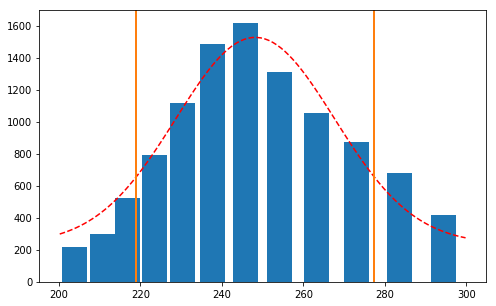

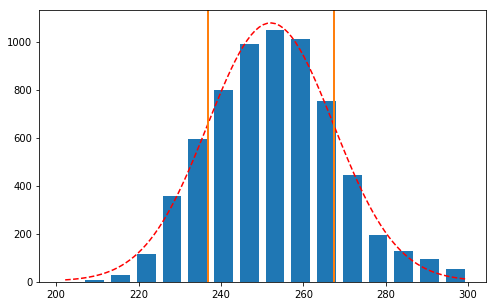

In [16]:
radiuses = np.loadtxt("radiuses.txt")
radiuses_filtered = radiuses[np.logical_and(radiuses[:, 2] >= 216, radiuses[:, 2] <= 264)]
filtered = create_set(radiuses, 250, r_tol=50, score_percentile=0.8, n1=1.5, n2=1)
print("{} images in the set".format(filtered.shape[0]))
classified = np.sum(filtered[:, 6] >= 0)
single_hits = np.sum(np.logical_or(filtered[:, 6] == 0, filtered[:, 6] == 3))
print("{} of them are classified, {} are single hits.".format(classified, single_hits))
print("{:.0f}%+-{:.0f}% single hit ratio in the set".format(100 * single_hits / classified, 196 / classified ** 1.5 * (single_hits * (classified - single_hits)) ** 0.5))

23993
(12,)


Text(394.49,1052.82,'c')

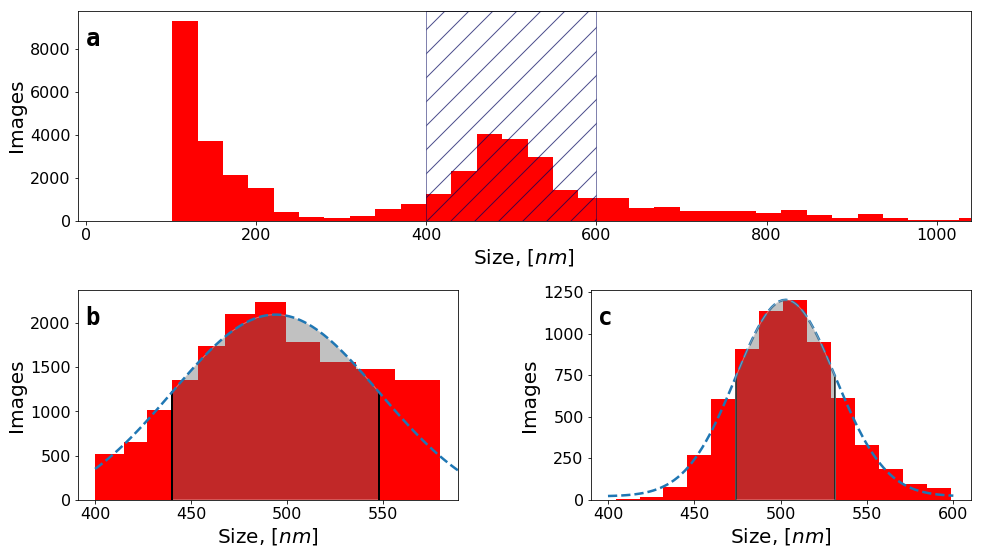

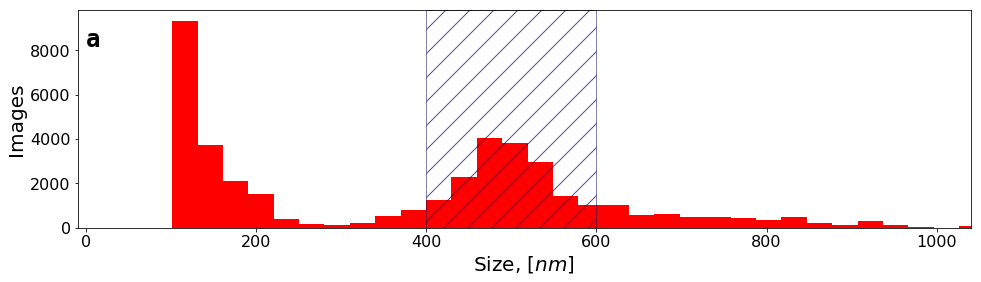

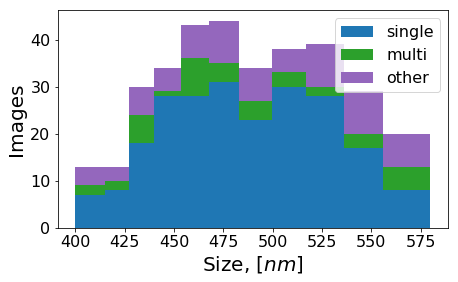

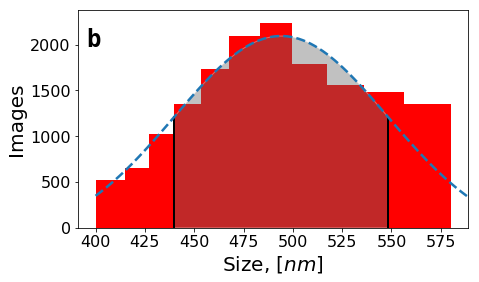

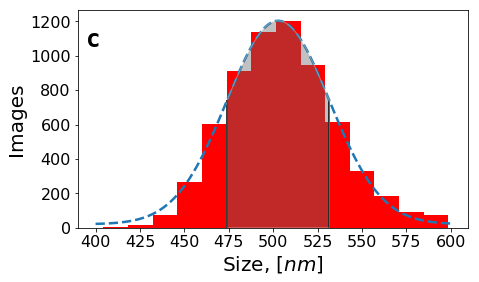

In [9]:
radiuses = np.loadtxt("radiuses.txt")
# discard runs with bad calibration
radiuses = radiuses[np.logical_or(radiuses[:, 0] < 318, radiuses[:, 0] > 320)]
radiuses_old = np.loadtxt("radiuses_init.txt")

import matplotlib.gridspec as gridspec

fig_gl = plt.figure(figsize=(16, 9))
gs = gridspec.GridSpec(ncols=2, nrows=2, figure=fig_gl, hspace=0.33, wspace=0.35)
ax1 = fig_gl.add_subplot(gs[0, :])
ax2 = fig_gl.add_subplot(gs[1, 0])
ax3 = fig_gl.add_subplot(gs[1, 1])

width = 16
height = 4
fig = plt.figure(figsize=(width, height))
ax = fig.add_subplot(111)
plt.xlabel("Size, [$\it{nm}$]", fontsize=20)
plt.ylabel("Images", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.hist(2 * np.concatenate((radiuses_old[radiuses_old[:, 2] > 0, 2], radiuses_old[radiuses_old[:, 3] > 0, 3])),
         bins=120,
         color=('red'))
plt.xlim([-10, 1040])
xb = ax.get_xlim()
yb = ax.get_ylim()
x = xb[0] + (xb[1] - xb[0]) * 5 / 490 * 14 / width
y = yb[1] - (yb[1] - yb[0]) * 1730.15 / 20730.15 * 8 / height

verts = [(400, 0), (400, yb[1]), (600, yb[1]), (600, 0)]
poly = Polygon(verts, edgecolor='xkcd:dark blue', zorder=1, hatch="/", fill=False, linewidth=0.7, alpha=0.7)
ax.add_patch(poly)

plt.text(x, y, "a", fontsize=24, weight="bold", family="monospace")
print(np.sum(radiuses[:, 2] > 0))

ax1.set_xlabel("Size, [$\it{nm}$]", fontsize=20)
ax1.set_ylabel("Images", fontsize=20)
ax1.tick_params(labelsize=16)
ax1.hist(2 * np.concatenate((radiuses_old[radiuses_old[:, 2] > 0, 2], radiuses_old[radiuses_old[:, 3] > 0, 3])),
         bins=120,
         color=('red'))
ax1.set_xlim([-10, 1040])
poly1 = Polygon(verts, edgecolor='xkcd:dark blue', zorder=1, hatch="/", fill=False, linewidth=0.7, alpha=0.7)
ax1.add_patch(poly1)
ax1.text(x, y, "a", fontsize=24, weight="bold", family="monospace")

m = 2
print((m * pixel_edges(200, 290)).shape)
width = 7
height = 4
#style="bar"
style="no"
fig = plt.figure(figsize=(width, height))
ax = fig.add_subplot(111)
plt.xlabel("Size, [$\it{nm}$]", fontsize=20)
plt.ylabel("Images", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
rad_cond = np.logical_and(radiuses[:, 2] <= 290, radiuses[:, 2] > 200)
class_radiuses = radiuses[np.logical_and(radiuses[:, 6] >= 0, rad_cond)]
values, edges, patches = ax.hist(m * np.array((np.concatenate((class_radiuses[class_radiuses[:, 6] == 0, 2], 
          class_radiuses[class_radiuses[:, 6] == 3, 2])),
          class_radiuses[class_radiuses[:, 6] == 1, 2],
          np.concatenate((class_radiuses[class_radiuses[:, 6] == 2, 2],
          class_radiuses[class_radiuses[:, 6] == 4, 2])))), 
         stacked=True, 
         label=["single", "multi", "other"],
         bins=(m * pixel_edges(200, 290)),
         color=('C0', 'C2', 'C4'))
plt.legend(fontsize=16)
xlim = ax.get_xlim()


fig = plt.figure(figsize=(width, height))
ax = fig.add_subplot(111)
plt.xlabel("Size, [$\it{nm}$]", fontsize=20)
plt.ylabel("Images", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
r_cond = np.logical_and(radiuses[:, 2] > 200, radiuses[:, 2] <= 290)
run_cond = np.logical_and(radiuses[:, 0] >= 0, radiuses[:, 0] <= 4420)
values, edges, patches = ax.hist(m * radiuses[np.logical_and(r_cond, run_cond), 2], bins=m * pixel_edges(200, 290), color="red", alpha=1)
if style == "bar":
    del fig, ax
    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_subplot(111)
    plt.xlabel("Size, [$\it{nm}$]", fontsize=20)
    plt.ylabel("Images", fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    ax.bar(coords, values, width=1, color="red", zorder=10)

def gauss(x, *p):
    a, b, c, d = p
    y = a*np.exp(-np.power((x - b), 2.)/(2. * c**2.)) + d
    return y

coords = 0.5 * (edges[1:] + edges[:-1])
coords = [c for c, v in zip(coords, values) if v > 400]
values = [v for v in values if v > 400]
p_initial = [1., m * 250., 20., 0.]
popt, pcov = optimize.curve_fit(gauss, coords[:-1], values[:-1], p0=p_initial)
coef, mean, sigma, add = popt
plt.ylim([0, 2375])
plt.xlim(xlim)
ax.plot(np.linspace(m * rmin, m * rmax, 100), gauss(np.linspace(m * rmin, m * rmax, 100), *popt), linestyle="--", linewidth=2.5, zorder=20)
ix = np.linspace(mean-sigma, mean+sigma)
iy = gauss(ix, *popt)
verts = [(mean-sigma, 0), *zip(ix, iy), (mean+sigma, 0)]
poly = Polygon(verts, facecolor='0.4', edgecolor='0.9', zorder=1, alpha=0.4)
ax.axvline(ix[0], 0, iy[0] / ax.get_ylim()[1], linewidth=2, color="k", zorder=15)
ax.axvline(ix[-1], 0, iy[-1] / ax.get_ylim()[1], linewidth=2, color="k", zorder=15)
ax.add_patch(poly)
xb = ax.get_xlim()
yb = ax.get_ylim()
x = xb[0] + (xb[1] - xb[0]) * 5 / 490 * 14 / width
y = yb[1] - (yb[1] - yb[0]) * 1730.15 / 20730.15 * 8 / height
plt.text(x, y, "b", fontsize=24, weight="bold", family="monospace")

ax2.set_xlabel("Size, [$\it{nm}$]", fontsize=20)
ax2.set_ylabel("Images", fontsize=20)
ax2.tick_params(labelsize=16)
ax2.hist(m * radiuses[np.logical_and(r_cond, run_cond), 2], bins=m * pixel_edges(200, 290), color="red", alpha=1)
ax2.set_ylim([0, 2375])
ax2.set_xlim(xlim)
ax2.plot(np.linspace(m * rmin, m * rmax, 100), gauss(np.linspace(m * rmin, m * rmax, 100), *popt), linestyle="--", linewidth=2.5, zorder=20)
ax2.axvline(ix[0], 0, iy[0] / ax.get_ylim()[1], linewidth=2, color="k", zorder=15)
ax2.axvline(ix[-1], 0, iy[-1] / ax.get_ylim()[1], linewidth=2, color="k", zorder=15)
poly2 = Polygon(verts, facecolor='0.4', edgecolor='0.9', zorder=1, alpha=0.4)
ax2.add_patch(poly2)
ax2.text(x, y, "b", fontsize=24, weight="bold", family="monospace")

m = 2
width = 7
height = 4
max_score = 0.6
x_label = "Size, [$\it{nm}$]"
r_idx = 3
bins = 14
rmin = 200
rmax = 300
ormin = 220
ormax = 274
fig = plt.figure(figsize=(width, height))
ax = fig.add_subplot(111)
ax.set_xlabel(x_label, fontsize=20)
ax.set_ylabel("Images", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
r_cond = np.logical_and(radiuses[:, 3] >= rmin, radiuses[:, 3] <= rmax)
old_rcond = np.logical_and(radiuses[:, 2] >= ormin, radiuses[:, 2] <= ormax)
r_cond = np.logical_and(r_cond, old_rcond)
run_cond = np.logical_and(radiuses[:, 0] >= 0, radiuses[:, 5] <= max_score)
values, edges, patches = ax.hist(m * radiuses[np.logical_and(r_cond, run_cond), r_idx], 
                                 bins=bins, 
                                 color="red", 
                                 rwidth=1,
                                 zorder=10)
coords = 0.5 * (edges[1:] + edges[:-1])

def gauss(x, *p):
    a, b, c, d = p
    y = a*np.exp(-np.power((x - b), 2.)/(2. * c**2.)) + d
    return y

p_initial = [1., m * 250., 20., 0.]
popt, pcov = optimize.curve_fit(gauss, coords, values, p0=p_initial, method="trf")
coef, mean, sigma, add = popt
ax.plot(np.linspace(m * rmin, m * rmax, 100), gauss(np.linspace(m * rmin, m * rmax, 100), *popt), linestyle="--", zorder=20, linewidth=2.5)

ix = np.linspace(mean-sigma, mean+sigma)
iy = gauss(ix, *popt)
verts = [(mean-sigma, 0), *zip(ix, iy), (mean+sigma, 0)]
poly = Polygon(verts, facecolor='0.4', edgecolor='0.9', zorder=21, alpha=0.4)
ax.axvline(ix[0], 0, iy[0] / ax.get_ylim()[1], linewidth=2, color="k", zorder=15)
ax.axvline(ix[-1], 0, iy[-1] / ax.get_ylim()[1], linewidth=2, color="k", zorder=15)
ax.add_patch(poly)
xb = ax.get_xlim()
yb = ax.get_ylim()
x = xb[0] + (xb[1] - xb[0]) * 5 / 490 * 14 / width
y = yb[1] - (yb[1] - yb[0]) * 1730.15 / 20730.15 * 8 / height
plt.text(x, y, "c", fontsize=24, weight="bold", family="monospace")
selected = radiuses[np.logical_and(r_cond, run_cond), :]
selected = selected[np.logical_and(selected[:, 3] >= (mean - np.abs(sigma)), selected[:, 3] <= (mean + np.abs(sigma))), :]

ax3.set_xlabel("Size, [$\it{nm}$]", fontsize=20)
ax3.set_ylabel("Images", fontsize=20)
ax3.tick_params("both", labelsize=16)
ax3.hist(m * radiuses[np.logical_and(r_cond, run_cond), r_idx], bins=bins, color="red", rwidth=1, zorder=10)
ax3.plot(np.linspace(m * rmin, m * rmax, 100), gauss(np.linspace(m * rmin, m * rmax, 100), *popt), linestyle="--", zorder=20, linewidth=2.5)
poly3 = Polygon(verts, facecolor='0.4', edgecolor='0.9', zorder=21, alpha=0.4)
ax3.axvline(ix[0], 0, iy[0] / ax.get_ylim()[1], linewidth=2, color="k", zorder=15)
ax3.axvline(ix[-1], 0, iy[-1] / ax.get_ylim()[1], linewidth=2, color="k", zorder=15)
ax3.add_patch(poly3)
ax3.text(x, y, "c", fontsize=24, weight="bold", family="monospace")

#fig_gl.savefig("figure7.pdf", format="pdf")